In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

/home/bb2020/mambaforge/envs/uncertainty/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# when running on CPU, I found that performance is pretty much the same as with many cores
torch.set_num_threads(1)

# Create task and RNN

In [5]:
from modular_rnn.connections import ConnectionConfig
from modular_rnn.models import MultiRegionRNN
from modular_rnn.loss_functions import MSEOnlyLoss

## Set parameters

In [6]:
# time constant of each neuron's the dynamics
tau = 100

# timestep of the simulation
dt = 5

# need this
alpha = dt / tau

# noise in the dynamics
noise = 0.05

# activation function of the neurons
nonlin_fn = F.relu

# how long the targets are shown
input_length = 40

In [7]:
# length of each trial
L = 1200

# number of trials in a batch
batch_size = 64

# special loss for the uncertainty task
loss_fn = MSEOnlyLoss(['hand'])

## Create task

In [8]:
from modular_rnn.tasks import CenterOutTaskWithReachProfiles

task = CenterOutTaskWithReachProfiles(dt, tau, L, batch_size, n_targets = 8, input_length = input_length)

2023-11-02 17:45:26.676782: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-02 17:45:27.286471: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none
2023-11-02 17:45:27.288266: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none


## Create RNN

In [9]:
# dictionary defining the modules in the RNN
# here we'll have a single region called motor_cortex
regions_config_dict = {
    'PMd' : {
        'n_neurons' : 50,
        'alpha' : alpha,
        'p_rec': 1.,
        #'rec_rank' : 1,
        'dynamics_noise' : noise,
    },
    'M1' : {
        'n_neurons' : 50,
        'alpha' : alpha,
        'p_rec': 1.,
        #'rec_rank' : 1,
        'dynamics_noise' : noise,
    }
}

# name and dimensionality of the outputs we want the RNN to produce
output_dims = task.output_dims

# name and dimensionality of the inputs we want the RNN to receive
input_dims = task.input_dims

In [10]:
rnn = MultiRegionRNN(
     input_dims,
     output_dims,
     alpha,
     nonlin_fn,
     regions_config_dict, 
     connection_configs = [
         ConnectionConfig('PMd', 'M1')
     ],
     input_configs = [
         ConnectionConfig('target', 'PMd'),
         ConnectionConfig('go_cue', 'PMd'),
     ],
     output_configs = [
         ConnectionConfig('M1', 'hand'),
     ],
     feedback_configs = []
)

# Train

  0%|          | 0/300 [00:00<?, ?it/s]

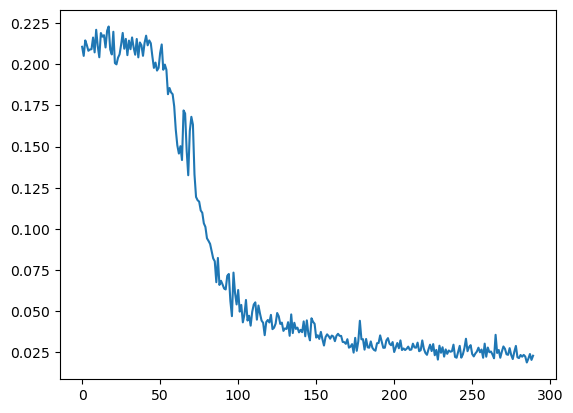

In [11]:
from modular_rnn.training import train

#if torch.cuda.is_available():
#    rnn.cuda()

losses = train(rnn, task, 300, loss_fn)

#rnn.cpu();

plt.plot(losses[10:]);

# Test the model's behavior on some test trials

Run a few batches of test trials

In [12]:
from modular_rnn.testing import run_test_batches

test_df = run_test_batches(10, rnn, task)

Produced "hand" trajectories

In [13]:
from pysubspaces.plotting import get_color_cycle

Text(0, 0.5, 'y')

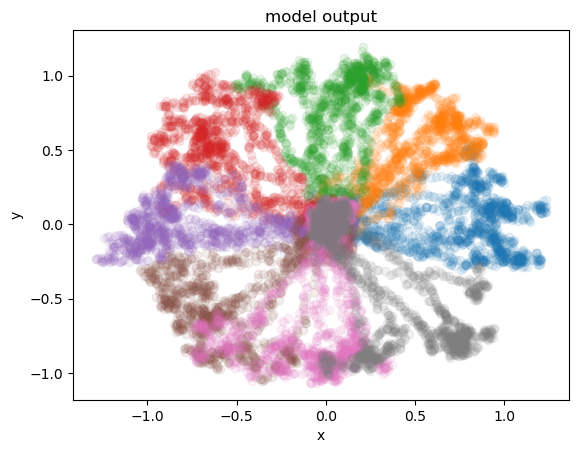

In [14]:
fig, ax = plt.subplots()

for (tid, target_df) in test_df.groupby('target_id'):
    for arr in target_df.hand_model_output.values[:10]:
        ax.scatter(*arr.T, alpha = 0.1, color = get_color_cycle()[tid])
        
ax.set_title('model output')
ax.set_xlabel('x')
ax.set_ylabel('y')

Hand velocities

In [15]:
from pyaldata import *

test_df = add_gradient(test_df, 'hand_model_output', 'model_vel')
test_df = add_norm(test_df, 'model_vel')

test_df = add_gradient(test_df, 'hand_target_output', 'target_vel')
test_df = add_norm(test_df, 'target_vel')

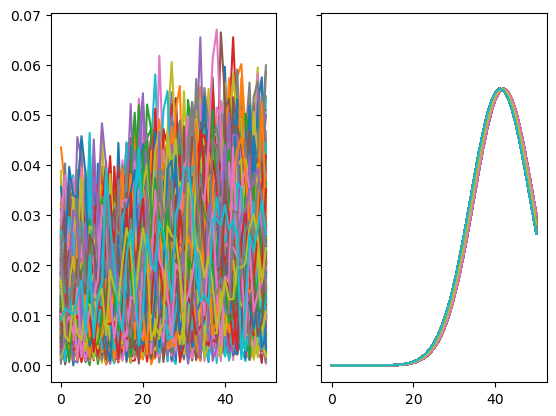

In [16]:
fig, ax = plt.subplots(ncols = 2, sharey = True)

for arr in restrict_to_interval(test_df, 'idx_go_cue', rel_start = -10, rel_end = 40).model_vel_norm.values:
    ax[0].plot(arr)
for arr in restrict_to_interval(test_df, 'idx_go_cue', rel_start = -10, rel_end = 40).target_vel_norm.values:
    ax[1].plot(arr)

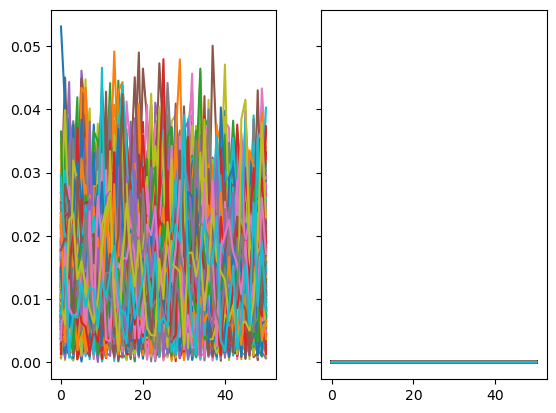

In [17]:
fig, ax = plt.subplots(ncols = 2, sharey = True)

for arr in restrict_to_interval(test_df, 'idx_target_on', rel_start = -10, rel_end = 40).model_vel_norm.values:
    ax[0].plot(arr)
for arr in restrict_to_interval(test_df, 'idx_target_on', rel_start = -10, rel_end = 40).target_vel_norm.values:
    ax[1].plot(arr)

Latent trajectories

In [18]:
import plotly.graph_objects as go
import plotly.express as px

In [19]:
from sklearn.decomposition import PCA

test_df = dim_reduce(test_df, PCA(30), 'PMd_rates', 'PMd_proj')
test_df = dim_reduce(test_df, PCA(30), 'M1_rates', 'M1_proj')

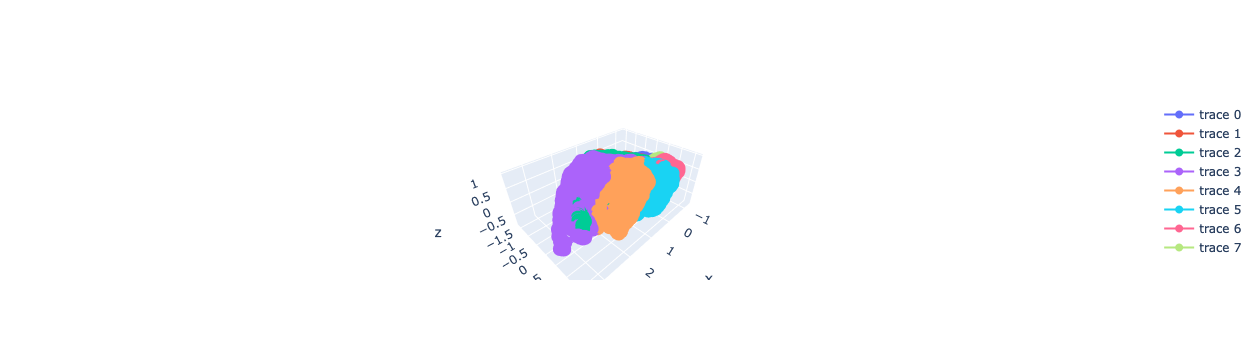

In [20]:
fig = go.Figure()

for (target_id, target_df) in test_df.groupby('target_id'):
    x = concat_trials(target_df.iloc[:10, :], 'PMd_proj')
    fig.add_scatter3d(
        x = x[:, 0],
        y = x[:, 1],
        z = x[:, 2],
    )

fig

Decoding target ID

In [21]:
from pysubspaces import get_classif_cv_scores_through_time
from sklearn.linear_model import RidgeClassifier

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Text(0, 0.5, 'accuracy')

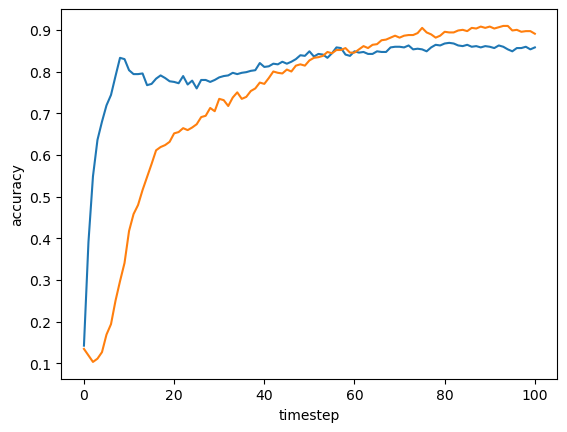

In [22]:
prep_td = restrict_to_interval(test_df, 'idx_target_on', rel_start = 0, rel_end = 100)

cv_scores = get_classif_cv_scores_through_time(prep_td, RidgeClassifier, 'PMd_proj', 'target_id')
plt.plot(cv_scores.mean(axis = 1))
cv_scores = get_classif_cv_scores_through_time(prep_td, RidgeClassifier, 'M1_proj', 'target_id')
plt.plot(cv_scores.mean(axis = 1))
plt.xlabel('timestep')
plt.ylabel('accuracy')

Just checking that the (cos, sin) input's length is okay

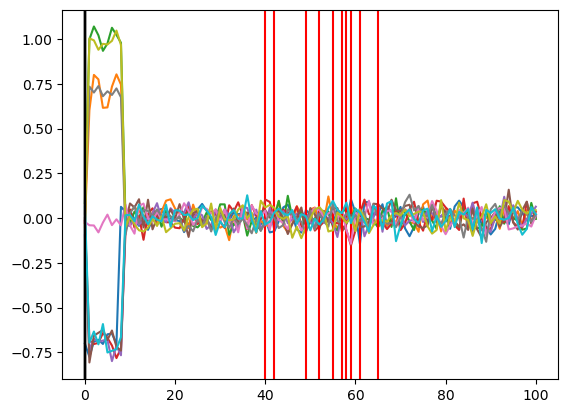

In [23]:
for i in range(10):
    plt.plot(prep_td.target_input.values[i][:, 0])
    plt.axvline(prep_td.idx_target_on.values[i], color = "black")
    plt.axvline(prep_td.idx_go_cue.values[i], color = "red")